In [1]:
import glob
#from pathlib import Path
import json
import os

import keras
import numpy as np
import pandas as pd
import tensorflow as tf

import preprocessing as pp

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

2024-01-07 11:35:20.320486: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-07 11:35:20.320660: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-07 11:35:20.425163: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-07 11:35:20.555864: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-07 11:35:22.218781: W tensorflow/compiler/tf2

In [20]:
length = 5
n_features=3
max_embed_length=500
out_embed_dim=4 # This may can be increased, default for screen2words: 2
label_length=1
training_frames = length + label_length
batch_size = 32

train_test_split = 0.25 # 1/4 the data is for testing
dataset_share = 0.2 # Should be 1.0 in production

In [4]:
def get_features_from_gestures(gesture_path):
  with tf.io.gfile.GFile(gesture_path) as f:
    gesture_json = json.load(f)
  trace_path = gesture_path.replace('gestures.json', '')
  # Throw away all gestures except the first
  gesture_items = list(gesture_json.items())
  # Remove empty gestures
  gesture_items = [gesture for gesture in gesture_items if gesture[1]]
  # TODO: Add column: isSwipe, if gesture has more than one entry
  if gesture_items and gesture_items[0]:
    gesture_dict = {gesture[0]:gesture[1][0] for gesture in gesture_items}
  else:
    gesture_dict = {}

  first_gesture_item = list(gesture_dict.items())
  if (not gesture_dict) or (not first_gesture_item[0]) or (not first_gesture_item[0][1]):
    # Return empty dataframe, if no data is available
    return pd.DataFrame(columns=['x', 'y']), trace_path
  
  gesture_df = pd.DataFrame(gesture_dict).transpose()
  gesture_df.columns = ['x', 'y']
  return gesture_df, trace_path

In [6]:
traces_prefix = "../sources/datasets/RICO/traces/filtered_traces"
path_to_gesture_json = f"{traces_prefix}/*/trace_*/gestures.json"
path_to_gesture_json

'../sources/datasets/RICO/traces/filtered_traces/*/trace_*/gestures.json'

In [7]:
gesture_json_paths = glob.glob(path_to_gesture_json)
len(gesture_json_paths)

10292

In [8]:
def get_features_from_tree(frame_index, trace_path):
  file_prefix = f"{trace_path}view_hierarchies/{frame_index}"
  features_dict = pp.create_simple_features(file_prefix)
  if features_dict is None:
    return None
  del features_dict['node_id']
  feature_items = list(features_dict.items())
  #feature_items = to_var_len_feature_dict(feature_items).items()
  tree_feature_df = pd.DataFrame(feature_items, columns=['feat', frame_index])
  tree_feature_df = tree_feature_df.set_index('feat')
  tree_feature_df = tree_feature_df.transpose()
  return tree_feature_df
  #return pd.DataFrame(features_adapt, index=[frame_index])

In [14]:
gesture_path = gesture_json_paths[43]
gesture_df, trace_path = get_features_from_gestures(gesture_path)
frameIndex = gesture_df.index.values[0]
feature_df = get_features_from_tree(frameIndex, trace_path)
feature_df

feat,obj_dom_pos,type_id_seq,visibility_seq,visibility_to_user_seq,clickable_seq,cord_x_seq_start,cord_x_seq_end,cord_y_seq_start,cord_y_seq_end
391,"[1, 1, 7, 2, 2, 6, 2, 6, 2, 2, 7, 1, 3, 3, 5, ...","[4, 4, 4, 4, 4, 4, 4]","[1, 1, 1, 1, 0, 1, 1]","[1, 1, 1, 1, 0, 1, 1]","[0, 0, 0, 0, 0, 0, 1]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0]","[0.0, 0.0, 0.934375, 0.0, 0.0, 0.0328125, 0.03...","[1.0, 0.934375, 1.0, 0.0328125, 0.0, 0.934375,..."


In [15]:
all_feat_df = pd.concat([gesture_df, feature_df], axis=1)
all_feat_df

,x,y,obj_dom_pos,type_id_seq,visibility_seq,visibility_to_user_seq,clickable_seq,cord_x_seq_start,cord_x_seq_end,cord_y_seq_start,cord_y_seq_end
391,0.515094,0.732075,"[1, 1, 7, 2, 2, 6, 2, 6, 2, 2, 7, 1, 3, 3, 5, ...","[4, 4, 4, 4, 4, 4, 4]","[1, 1, 1, 1, 0, 1, 1]","[1, 1, 1, 1, 0, 1, 1]","[0, 0, 0, 0, 0, 0, 1]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0]","[0.0, 0.0, 0.934375, 0.0, 0.0, 0.0328125, 0.03...","[1.0, 0.934375, 1.0, 0.0328125, 0.0, 0.934375,..."


In [16]:
#feature_df['type_id_seq'].iloc[0][0].dtype

In [ ]:
 # Get set of frames for each screen, but don't mix them during training LSTM
feature_traces = pd.DataFrame()
use_embeddings = True

trace_progress = 0
for trace_id, gesture_path in enumerate(gesture_json_paths):
    trace_progress = trace_progress + 1
    if trace_progress % 100 == 0:
      print(f'Processed {trace_progress} of {len(gesture_json_paths)} ({trace_progress/len(gesture_json_paths):.0%}) traces.\r', end="")
    gesture_df, trace_path = get_features_from_gestures(gesture_path)
    # Traces with too few frames will be dropped
    if len(gesture_df) < training_frames:
        #print(f'Gesture (traceID: {trace_id}) has only {len(gesture_df)} of {training_frames} required frames: {gesture_path}')
        continue
    if use_embeddings: # Try without features for now, only gestures
        tree_features_df = pd.DataFrame()
        for frame_id in gesture_df.index.values:
            tree_feature_df = get_features_from_tree(frame_id, trace_path)
            if tree_feature_df is None:
              print(f'Frame {frame_id} has no feature data')
              continue
            tree_features_df = pd.concat([tree_features_df, tree_feature_df], axis=0)
        trace_features_df = pd.concat([gesture_df, tree_features_df], axis=1)
    else:
        trace_features_df = gesture_df
    trace_features_df['trace_id'] = trace_id
    feature_traces = pd.concat([feature_traces, trace_features_df], axis=0)

len(feature_traces)
        

Frame 7384 has no feature datatraces.
Frame 341 has no feature data traces.
Frame 521 has no feature data traces.


In [ ]:
feature_traces.head()

In [ ]:
feature_traces.describe()

In [22]:
gestures_only = True # Model only uses gestures / clicks, to determine the next click.
correct_gesture_shift = False # Shifts the gesture / click sequence one to the right, as the gesture of the current screen should be predicted, not the one on the next screen

# TODO set different input_dim for each feature
embedding_specs = [
  # feat_name, is_cat, input_dim, output_dim, # maybe needed: vocab_size
  ('x', False, 1, None, None),
  ('y', False, 1, None, None),
]

if not gestures_only:
  cat_embedding_specs = [
    ('cord_x_seq_start', False, max_embed_length, None, None),
    ('cord_x_seq_end', False, max_embed_length, None, None),
    ('cord_y_seq_start', False, max_embed_length, None, None),
    ('cord_y_seq_end', False, max_embed_length, None, None),
    ('obj_dom_pos', True, max_embed_length, out_embed_dim, 255),
    ('type_id_seq', True, max_embed_length, out_embed_dim, 10),
    ('visibility_seq', False, max_embed_length, None, None),
    ('visibility_to_user_seq', False, max_embed_length, None, None),
    ('clickable_seq', False, max_embed_length, None, None),
    # ('obj_dom_pos_2', True, max_embed_length, out_embed_dim),
  ]
  embedding_specs.extend(cat_embedding_specs)
  
considered_features = [specs[0] for specs in embedding_specs]
considered_cat_features = [specs[0] for specs in embedding_specs if specs[1]]

print(considered_features)
print(considered_cat_features)

['x', 'y']
[]


In [23]:
feature_traces_preprocessed = feature_traces
print(len(feature_traces_preprocessed))
feature_traces_preprocessed = feature_traces_preprocessed.dropna()
feature_traces_preprocessed = feature_traces_preprocessed[considered_features + ['trace_id']]
print(len(feature_traces_preprocessed))
feature_traces_preprocessed.head()

50304
50301


,x,y,trace_id
370,0.825156,0.351732,3
488,0.373016,0.224026,3
526,0.563492,0.898268,3
614,0.169072,0.336580,3
642,0.346080,0.136364,3


In [24]:
import math
import statistics

# Preprocess data
# for t,v in keys_to_dtype.items():
#   # try to convert float to list
#   feature_traces_preprocessed[t] = feature_traces_preprocessed[t].apply(lambda x : [np.nan if (y is None or isinstance(y, float)) else y for y in x] if isinstance(x, list) else [x])
# 
# #lens of list
# print(feature_traces_preprocessed.isna().sum())
# feature_traces_preprocessed

# List of median value count for each feature.
feat_median_array_length = {}

# Check if feature is an array
isFeatList = (feature_traces_preprocessed.map(type) == list).all(axis='rows')
max_dom_pos = 500 # see screen2words

def print_feat_infos(feat_name, isList):
  print(f'Handle Feature "{feat_name}":')
  print(f'Shape of Feature "{np.array(feature_traces_preprocessed[feat_name]).shape}":')
  if isList:
    lengths_of_feature = feature_traces_preprocessed[feat_name].map(len)
    # FIXME: check why header is given as first row
    # print(lengths_of_feature)
    # for f_length in lengths_of_feature:
    #   if not isinstance(f_length, float):
    #     print(f_length)
    try:
      median_value = statistics.median(lengths_of_feature)
      feat_median_array_length[feat_name] = median_value
      print(f'\thas median array length of {median_value}')
      print(f'\thas max array length of {max(lengths_of_feature)}')
    except:
      print(f'Failed to process lengths:\n {lengths_of_feature}')
      raise
  
    # Remove all NaN inner values (?): TODO check!!!
    feature_traces_preprocessed[feat_name] = feature_traces_preprocessed[feat_name].map(lambda row: [x for x in row if not math.isnan(x)])
  
    # Extract the maximum value:
    allvals = [x for xs in feature_traces_preprocessed[feat_name] for x in xs]
    print(f'\thas median value of {statistics.median(allvals)}')
    print(f'\thas max value of {max(allvals)}')
  
    # Pad all values to same length
    # TODO need to pad to higher values per input
    feat_pad = keras.utils.pad_sequences(feature_traces_preprocessed[feat_name], value=0, padding='post', maxlen=max_dom_pos)
    feature_traces_preprocessed[feat_name] = feat_pad.tolist()
  else:
    print(f'\tis single value only')

for feat_name, isList in isFeatList.items():
  print_feat_infos(feat_name, isList)

feat_median_array_length

Handle Feature "x":
Shape of Feature "(50301,)":
	is single value only
Handle Feature "y":
Shape of Feature "(50301,)":
	is single value only
Handle Feature "trace_id":
Shape of Feature "(50301,)":
	is single value only


{}

In [25]:
# feature_traces_flatten = feature_traces_preprocessed
# for feat_name, isList in isFeatList.items():
#   if isList:
#     max_len = len(feature_traces_flatten[feat_name])
#     feature_traces_flatten = feature_traces_flatten.drop(feat_name, axis= 1)
#     feature_traces_flatten[[f'{feat_name}_{i}' for i in max_len]] = pd.DataFrame(feature_traces_preprocessed[feat_name].tolist(), index= feature_traces_preprocessed.index)
#     #feature_traces_preprocessed = feature_traces_preprocessed + feature_traces_preprocessed.teams.apply(pd.Series)
#     #df3.columns = ['team1', 'team2']

In [26]:
feature_traces_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50301 entries, 370 to 1453
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   x         50301 non-null  float64
 1   y         50301 non-null  float64
 2   trace_id  50301 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 1.5+ MB


In [27]:
# The data is split by trace and not by frame windows as otherwise the model would be trained with similar apps before
feature_traces_list = [pd.DataFrame(x[1]).drop('trace_id', axis=1) for x in feature_traces_preprocessed.groupby('trace_id')]

In [28]:
feature_traces_list[0]
# len(feature_traces_preprocessed[0].iloc[0]['obj_dom_pos'])

,x,y
370,0.825156,0.351732
488,0.373016,0.224026
526,0.563492,0.898268
614,0.169072,0.336580
642,0.346080,0.136364
683,0.413420,0.257576
688,0.090188,0.070346
700,0.257576,0.786797
709,0.078644,0.900433
736,0.159452,0.980519


In [31]:
# TODO: add validation split and use test split only to evaluation

all_size = len(feature_traces_list)
print(f'All size: {all_size}')
share_size = math.floor(all_size * dataset_share)
print(f'Share size: {share_size}')
test_size = math.floor(share_size * train_test_split)
test_ind = share_size - test_size
print(f'Train size: {test_ind}')
print(f'Test size: {test_size}')

train_traces = feature_traces_list[:test_ind]
test_traces = feature_traces_list[test_ind:share_size]

All size: 4278
Share size: 855
Train size: 642
Test size: 213


In [32]:
#df['obj_dom_pos'].dtype

In [34]:
from keras.layers import Normalization

isScale = False # Currently all values are already scaled, as far as known
if isScale:
  scaler = Normalization()
  scaler_invert = Normalization(invert=True)
  
  print('Adapt scaler')
  for train in train_traces:
    scaler.adapt(train[['x','y']])
    scaler_invert.adapt(train[['x','y']])
  
  print('Scale train data')
  scaled_train_traces = train_traces
  for train in train_traces[['x','y']]:
    scaled_train_traces[['x','y']] = scaler(train)
  
  print('Scale test data')
  scaled_test_traces = test_traces
  for test in test_traces[['x','y']]:
    scaled_test_traces[['x','y']] = scaler(test)
  
  print(scaler_invert(scaled_train_traces[0]))
else:
  scaled_train_traces = train_traces
  scaled_test_traces = test_traces
  

In [35]:
scaled_train_traces[0]


,x,y
370,0.825156,0.351732
488,0.373016,0.224026
526,0.563492,0.898268
614,0.169072,0.336580
642,0.346080,0.136364
683,0.413420,0.257576
688,0.090188,0.070346
700,0.257576,0.786797
709,0.078644,0.900433
736,0.159452,0.980519


In [36]:
# from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
# # Replace by timeseries_dataset_from_array
# generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)
# validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)
# len(generator)

In [37]:
# X,y = generator[0]
# X

In [38]:
# Convert to list of dicts
scaled_train_traces = [v.to_dict(orient='records') for v in scaled_train_traces]
scaled_test_traces = [v.to_dict(orient='records') for v in scaled_test_traces]

In [39]:
def create_fake_dataset(length=5):
  my_arr = []
  for i in range(0, length):
    my_dict = {
      'x': np.random.uniform(0, 1),
      'y': np.random.uniform(0, 1),
      'obj_dom_pos': np.random.randint(0, 255, size=max_embed_length),
    }
    my_arr.append(my_dict)
  return my_arr

override_with_fake = False
if override_with_fake:
  scaled_train_traces = [create_fake_dataset(30) for i in range(0, 3)]
  scaled_test_traces = [create_fake_dataset(20) for i in range(0, 3)]

scaled_train_traces[0]
#for x in scaled_train_traces[0]:
#  print(x)

[{'x': 0.8251563251563252, 'y': 0.35173160173160173},
 {'x': 0.373015873015873, 'y': 0.22402597402597402},
 {'x': 0.5634920634920635, 'y': 0.8982683982683982},
 {'x': 0.16907166907166907, 'y': 0.3365800865800866},
 {'x': 0.3460798460798461, 'y': 0.13636363636363635},
 {'x': 0.4134199134199134, 'y': 0.25757575757575757},
 {'x': 0.09018759018759019, 'y': 0.07034632034632035},
 {'x': 0.25757575757575757, 'y': 0.7867965367965368},
 {'x': 0.07864357864357864, 'y': 0.9004329004329005},
 {'x': 0.15945165945165946, 'y': 0.9805194805194806}]

In [48]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [49]:
from functools import reduce
def make_dataset_from_generator(data):
  generator = TimeseriesGenerator(data, data, length=length, batch_size=1)
  # shuffle=False, # TODO: Shuffle if possible
  return generator

# def reduce_generators(a,b):
#   a = list(map(lambda a1: a1, a))
#   b = list(map(lambda b1: b1, b))
#   return np.concatenate((a, b))

train_generators = list(map(make_dataset_from_generator,scaled_train_traces))
validation_generators = list(map(make_dataset_from_generator,scaled_test_traces))
print(f'#train generators: {len(train_generators)}')
print(f'#test generators: {len(validation_generators)}')
generator = train_generators[0]
validation_generator = validation_generators[0]
generator[0]
# train_dataset = reduce(reduce_generators, train_generators)
# print(train_dataset)

# print(generator)
# X,y = generator[0]
# print('X')
# print(X)
# print('y')
# print(y)

#train generators: 642
#test generators: 213


(array([[{'x': 0.8251563251563252, 'y': 0.35173160173160173},
         {'x': 0.373015873015873, 'y': 0.22402597402597402},
         {'x': 0.5634920634920635, 'y': 0.8982683982683982},
         {'x': 0.16907166907166907, 'y': 0.3365800865800866},
         {'x': 0.3460798460798461, 'y': 0.13636363636363635}]],
       dtype=object),
 array([{'x': 0.4134199134199134, 'y': 0.25757575757575757}], dtype=object))

In [50]:
from keras.models import Model
from keras.layers import Dense,LSTM,Embedding, Input
from keras.callbacks import EarlyStopping

In [51]:
generator[0][1]#[0][0]#['y'][:]

array([{'x': 0.4134199134199134, 'y': 0.25757575757575757}], dtype=object)

In [52]:
def merge_generators(generators):
  generators = [[v for v in g] for g in generators]
  return reduce(lambda a,b: a + b, generators)

def transform_generators_to_tuple(generators):
  timeseries = merge_generators(generators)
  # TODO: find out, why these arrays are nested in [0] and [0,0]
  return [xY[0][0] for xY in timeseries], [xY[1][0] for xY in timeseries]

# Filter out a feature from a time window to its own array
def filter_var(window, feat_name):
  return [step[feat_name] for step in window]

# def filter_var(generator, feat_name):
#   return [[[filter_var_row(row, feat_name) for row in g[0]],filter_var_row(g[1], feat_name)] for g in generator]

In [53]:
train_X, train_y = transform_generators_to_tuple(train_generators)
print(len(train_X))
print(len(train_y))

4095
4095


In [54]:
train_X[0]

array([{'x': 0.8251563251563252, 'y': 0.35173160173160173},
       {'x': 0.373015873015873, 'y': 0.22402597402597402},
       {'x': 0.5634920634920635, 'y': 0.8982683982683982},
       {'x': 0.16907166907166907, 'y': 0.3365800865800866},
       {'x': 0.3460798460798461, 'y': 0.13636363636363635}], dtype=object)

In [55]:
train_y[0]

{'x': 0.4134199134199134, 'y': 0.25757575757575757}

In [56]:
test_X, test_y = transform_generators_to_tuple(validation_generators)

In [57]:
def transform_window_to_input(window, feat_name, is_list):
  if is_list:
    return filter_var(window, feat_name)
  else:
    feat_vals = filter_var(window, feat_name)
    feat_vals = np.expand_dims(feat_vals, axis=1) # Bring to same shape as cats, just wrap the inner value in an array
    return feat_vals

# Transform list of windows of features to list of features of windows
def transform_X_to_inputs(X):
  inputs = []
  for feat_name, is_cat, input_dim, output_dim, vocab_dim in embedding_specs:
    feat_input = [transform_window_to_input(window, feat_name, is_list=input_dim > 1) for window in X]
    inputs.append(np.array(feat_input))
  return inputs

def transform_y_to_labels(y):
  labels_pos_x = filter_var(y, 'x')
  labels_pos_y = filter_var(y, 'y')
  return [np.array(labels_pos_x), np.array(labels_pos_y)]

train_inputs = transform_X_to_inputs(train_X)
train_labels = transform_y_to_labels(train_y)

test_inputs = transform_X_to_inputs(test_X)
test_labels = transform_y_to_labels(test_y)

for inp in train_inputs:
  print(inp.shape)

(4095, 5, 1)
(4095, 5, 1)


In [58]:
# https://stackoverflow.com/questions/52627739/how-to-merge-numerical-and-embedding-sequential-models-to-treat-categories-in-rn/52629902#comment136040845_52629902

In [60]:
numerical_inputs = []
cat_inputs = []
cat_embedded = []
for i, (feat_name, is_cat, input_length, out_embed_dim, vocab_dim) in enumerate(embedding_specs):
  print(i, feat_name, is_cat, input_length, out_embed_dim)
  if is_cat:
    # We have multiple inputs for the same category
    input = Input(shape=(length, input_length), name=feat_name)
    cat_inputs.append(input)
    embed = Embedding(input_dim=vocab_dim, output_dim=out_embed_dim, mask_zero=True)(input)
    # Reshape embedding layer to be flattened:
    # we have `input_dim` values for this category, which should each be embedded in its own column
    # the third dimension is used as embedding dimension, which is shared with the float values dimension
    embed = keras.layers.Reshape((length, input_length * out_embed_dim))(embed)
    # TODO: play around with multiple DENSE and DROPOUT layers to reduce values of each category, which can be extremely high!! But also to raise performance.
    embed = Dense(4)(embed)
    cat_embedded.append(embed)
  elif input_length > 1:
    input = Input(shape=(length, input_length), name=feat_name)
    embed = Dense(4)(input)
    numerical_inputs.append(input)
  else:
    input = Input(shape=(length, input_length), name=feat_name)
    numerical_inputs.append(input)


numerical_merged = keras.layers.concatenate(numerical_inputs)
if len(cat_embedded) > 0:
  cat_merged = keras.layers.concatenate(cat_embedded)
  merged = keras.layers.concatenate([numerical_merged, cat_merged])
else:
  merged = numerical_merged

# Consider adding `stateful=True` and `model.reset_states()` to keep interpreting windows as continous batch e.g. for one app.
# See: https://stackoverflow.com/a/50235563/5164462
lstm_out = LSTM(128, return_sequences=False)(merged)
# Can remove the dense layer, if want to predict the whole screen
dense = Dense(2)(lstm_out)

model = Model(numerical_inputs + cat_inputs, dense)
model.summary()

0 x False 1 None
1 y False 1 None


2024-01-07 11:51:05.449080: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-07 11:51:05.705654: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-07 11:51:05.705908: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 x (InputLayer)              [(None, 5, 1)]               0         []                            
                                                                                                  
 y (InputLayer)              [(None, 5, 1)]               0         []                            
                                                                                                  
 concatenate_2 (Concatenate  (None, 5, 2)                 0         ['x[0][0]',                   
 )                                                                   'y[0][0]']                   
                                                                                                  
 lstm (LSTM)                 (None, 128)                  67072     ['concatenate_2[0][0]']   

In [61]:
model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss',patience=4)

In [62]:
model.fit(
  train_inputs,
  train_labels,
  epochs=50,
  validation_data=(test_inputs,test_labels),
  callbacks=[early_stop],
  batch_size=batch_size
)

Epoch 1/50


2024-01-07 11:51:19.246645: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-07 11:51:19.772892: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f72785bb570 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-07 11:51:19.772938: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 970, Compute Capability 5.2
2024-01-07 11:51:19.808881: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1704624679.937506   10499 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


128/128 [==============================] - 5s 11ms/step - loss: 0.0840 - val_loss: 0.0850
Epoch 2/50
128/128 [==============================] - 1s 6ms/step - loss: 0.0799 - val_loss: 0.0837
Epoch 3/50
128/128 [==============================] - 1s 7ms/step - loss: 0.0792 - val_loss: 0.0835
Epoch 4/50
128/128 [==============================] - 1s 6ms/step - loss: 0.0790 - val_loss: 0.0840
Epoch 5/50
128/128 [==============================] - 1s 7ms/step - loss: 0.0793 - val_loss: 0.0838
Epoch 6/50
128/128 [==============================] - 1s 6ms/step - loss: 0.0795 - val_loss: 0.0837
Epoch 7/50
128/128 [==============================] - 1s 6ms/step - loss: 0.0793 - val_loss: 0.0872


In [ ]:
# For clicks only:
# loss: 0.0793
# val_loss: 0.0872
# 7 epochs, until early stop

# With features, but clicks not shifted:
# loss: 0.0822
# val_loss: 0.0951
# 15 epochs until early stop

<AxesSubplot: >

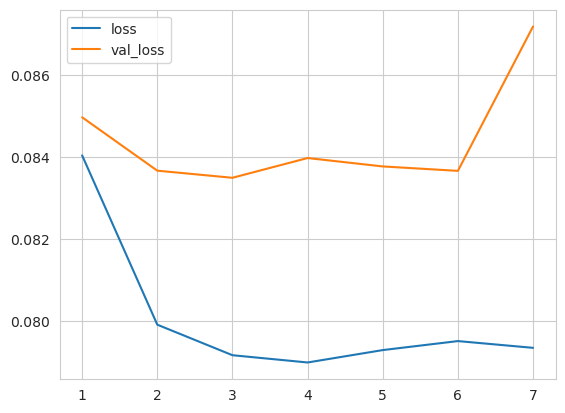

In [65]:
loss = pd.DataFrame(model.history.history)
loss. index += 1
loss.plot()

In [130]:
## Evaluate on Test Data

In [236]:
scaled_test_traces_lengths = list(map(len, scaled_test_traces))
# Get the longest trace
longest_scaled_test_trace = max(scaled_test_traces_lengths)
print(f'Length of longest test trace: {longest_scaled_test_trace}')
index_longest_scaled_test_trace = scaled_test_traces_lengths.index(max(scaled_test_traces_lengths))
print(f'Index of longest test trace: {index_longest_scaled_test_trace}')

scaled_test_traces[105]

Length of longest test trace: 42
Index of longest test trace: 222


[{'x': 0.5788840788840789,
  'y': 0.8614718614718615,
  'cord_x_seq_start': [0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
  

In [237]:
my_prediction_trace = index_longest_scaled_test_trace
scaled_test = scaled_test_traces[my_prediction_trace]

In [238]:
test_predictions = []

first_eval_batch = scaled_test[:length] # Use first batch from a test set and predict the next value
first_eval_batch = [first_eval_batch] # Must be wrapped in an array to represent shape of X (here: only one entry)
first_eval_batch = transform_X_to_inputs(first_eval_batch)
current_batch = first_eval_batch

print(current_batch)

# Of course cannot predict more than one step, as we only predict gesture_pos_x and gesture_pos_y and not the whole tree
# for i in range(len(scaled_test)):
# 
#   # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
#   current_pred = model.predict(current_batch)[0]
# 
#   # store prediction
#   test_predictions.append(current_pred)
#   
#   # drop first value
#   current_batch = [feat_input[:,1:,:] for feat_input in current_batch]
# 
#   # update batch to now include prediction
#   current_batch = np.append(current_batch,[[current_pred]],axis=1)

[array([[[0.94147753],
        [0.71361816],
        [0.52136182],
        [0.51661475],
        [0.48813232]]]), array([[[0.06275033],
        [0.88651535],
        [0.65554072],
        [0.70894526],
        [0.40453939]]]), array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]]), array([[[1, 1, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]]), array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]]), array([[[1, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [1, 0, 1, ..., 0, 0, 0],
        [1, 0, 1, ..., 0, 0, 0],
        [1, 0, 1, ..., 0, 0, 0]]]), array([[[  1,   1,  97, ...,   0,   0,   0],
        [  1,   1,  88, ...,   0,   0,   0],
        [  

In [239]:
# Current prediction only
current_pred = model.predict(current_batch)
print(current_pred)
test_predictions.append(current_pred[0]) # Model only predicts one gesture per batch, this can be "easily" changed by handing over a batch of labels during training and setting `return_sequences` to true
test_predictions

1/1 [==============================] - 36s 36s/step
[[0.25882384 0.33042452]]


[array([0.25882384, 0.33042452], dtype=float32)]

In [240]:
test_predictions = np.array(test_predictions)
test_predictions

array([[0.25882384, 0.33042452]], dtype=float32)

In [253]:
next_values = scaled_test[length:length + 1] # Remove the first batch and just select the next one, as we don't predict more right now
next_labels = transform_y_to_labels(next_values)
next_labels = np.transpose(next_labels, (1,0))
next_labels

array([[0.17007862, 0.97329773]])

In [254]:
if isScale:
  # TODO: validate
  true_predictions_labels = scaler_invert(test_predictions)
  true_next_labels = scaler_invert(next_labels)
else:
  true_predictions_labels = test_predictions
  true_next_labels = next_labels

comparison = np.concatenate([true_next_labels, true_predictions_labels], axis=1)
comparison_df = pd.DataFrame(comparison, columns=['x','y','PredictionsX', 'PredictionsY'])
comparison_df

,x,y,PredictionsX,PredictionsY
0,0.170079,0.973298,0.258824,0.330425


<AxesSubplot: >

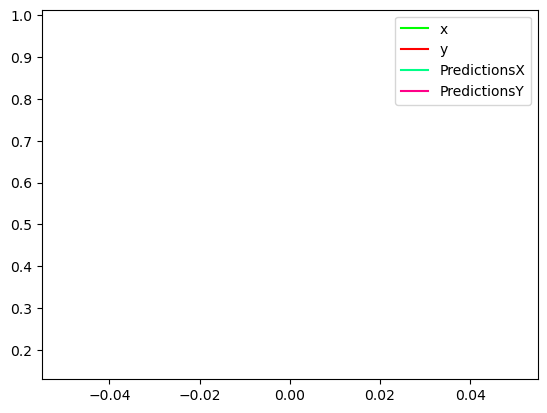

In [255]:
comparison_df.plot(color = ['#00FF00', '#FF0000', '#00FF88', '#FF0088'])

In [246]:
from sklearn.metrics import mean_squared_error
print(np.sqrt(mean_squared_error(comparison_df['x'],comparison_df['PredictionsX'])))
print(np.sqrt(mean_squared_error(comparison_df['y'],comparison_df['PredictionsY'])))

0.08874521846057506
0.6428732129139639


<AxesSubplot: xlabel='x', ylabel='y'>

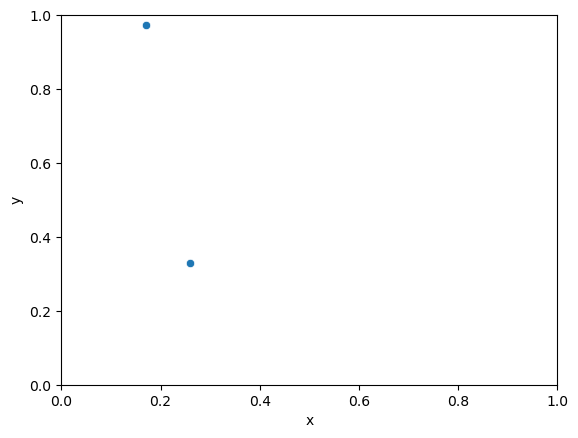

In [263]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.ylim(0, 1)
plt.xlim(0, 1)

comparison_2d = np.concatenate([true_next_labels, true_predictions_labels], axis=0)
comparison_2d = pd.DataFrame(comparison_2d, columns=['x', 'y'])
sns.scatterplot(x='x', y='y', data=comparison_2d)
# comparison_2d.plot.scatter(x='x', y='y', c='DarkBlue')